<a href="https://colab.research.google.com/github/mrromaniuc/quantum-computing/blob/main/QC_VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%capture
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit-visualization
!pip install qiskit-ibm-provider
!pip install qiskit-ibm-runtime
!pip install qiskit-experiments
!pip install qiskit-circuit
!pip install imgaug==0.2.5
!pip install pylatexenc

In [7]:
!pip install qiskit-circuit

ERROR: Could not find a version that satisfies the requirement qiskit-circuit (from versions: none)
ERROR: No matching distribution found for qiskit-circuit


In [2]:
#Setting configuration to use matplotlib in drawings
!mkdir ~/.qiskit
!echo "[default]" > ~/.qiskit/settings.conf
!echo "circuit_drawer = mpl" >> ~/.qiskit/settings.conf
!more ~/.qiskit/settings.conf


#
# Loading IBM credentials
#
API_TOKEN_DIR="/content/drive/'My Drive'/'Colab Notebooks'/QC"
API_TOKEN_FILE="MY_API_TOKEN.txt"

#Mount the google drive first
from google.colab import drive
drive.mount('/content/drive')
#%cd /content/drive/'My Drive'/'Colab Notebooks'/QC
%cd $API_TOKEN_DIR

#Read the MY_API_TOKEN from file...
from qiskit_ibm_provider import IBMProvider
MY_API_TOKEN = ""
with open(API_TOKEN_FILE) as f:
  MY_API_TOKEN=f.readline()
IBMProvider.save_account(MY_API_TOKEN, overwrite=True)

[default]
circuit_drawer = mpl
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/QC


References:
* https://learning.quantum-computing.ibm.com/course/variational-algorithm-design/examples-and-applications


## Observable

In [20]:
from qiskit.quantum_info import SparsePauliOp

obs1=SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

In [21]:
#Getting the lowest eigenvalue fro obs1
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
  cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
  return cost

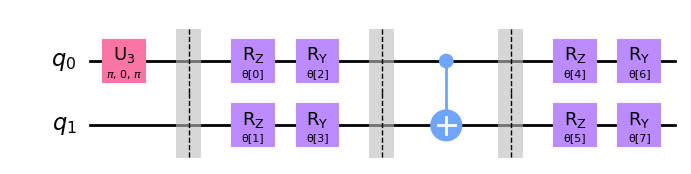

In [22]:
import numpy as np

ref_qc = QuantumCircuit(2)
ref_qc.x(0)
ref_qc.barrier()

var_qc = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    insert_barriers=True,
    reps=1
)
ansatz = ref_qc.compose(var_qc)
ansatz.decompose().draw("mpl")

In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend("ibmq_qasm_simulator")
session = Session(backend=backend)

estimator=Estimator(session=session)
sampler=Sampler(session=session)

In [24]:
#initial parameters - note above that we have 8 parameters in the circuit
x0=np.ones(8)

In [25]:
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(ansatz, obs1, estimator), method="COBYLA")

end_time=time.time()
exec_time = end_time - start_time

In [26]:
exec_time

438.8202841281891

In [27]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.9985
       x: [ 9.644e-01  8.808e-01  1.571e+00 -1.425e-02  2.603e+00
            5.257e-01  7.565e-01  7.811e-01]
    nfev: 82
   maxcv: 0.0

## Improve speed and accuracy

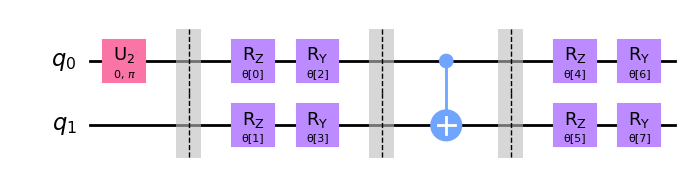

In [29]:
#Let's change the reference circuit and use Hadamard gate instead of the bit-flip (x gate)

import numpy as np

ref_qc = QuantumCircuit(2)
ref_qc.h(0)
ref_qc.barrier()

var_qc = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    insert_barriers=True,
    reps=1
)
ref_ansatz = ref_qc.compose(var_qc)
ref_ansatz.decompose().draw("mpl")


In [33]:
import time

start_time = time.time()

ref_result = minimize(cost_func_vqe, x0, args=(ref_ansatz, obs1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time
execution_time

484.6939787864685

In [32]:
ref_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.952999999999999
       x: [ 1.422e+00  7.481e-01  1.019e+00 -3.093e-02  2.395e+00
            2.451e+00  9.452e-01  9.567e-01]
    nfev: 94
   maxcv: 0.0

## Let's change the initial point (parameters)

In [34]:
import time

start_time = time.time()

x0 = [0, 0, 0, 0, 6, 0, 0, 0]

x0_1_result = minimize(cost_func_vqe, x0, args=(ansatz, obs1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time
execution_time

357.65173745155334

In [35]:
x0_1_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.9965
       x: [ 3.029e-02  1.002e+00 -1.070e-02  4.425e-03  6.241e+00
           -1.027e-02 -2.155e-02 -3.506e-02]
    nfev: 76
   maxcv: 0.0

In [36]:
import time

start_time = time.time()

x0 = 6 * np.ones(8)

x0_2_result = minimize(cost_func_vqe, x0, args=(ansatz, obs1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time
execution_time

377.6936881542206

In [37]:
x0_2_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.9750000000000005
       x: [ 7.024e+00  5.858e+00  6.300e+00  6.261e+00  6.022e+00
            5.840e+00  6.079e+00  6.146e+00]
    nfev: 75
   maxcv: 0.0

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table